# Univariate analysis
This notebook contains basic descriptives of the mutational signatures, as well as several univariate analysis comparing signature attributions by:
- Outcome (durable benefit versus non-durable benefit)
- Prior treatment

In [1]:
!mkdir -p figs/univariate
!mkdir -p figs/univariate/attribution

In [2]:
from matplotlib import pyplot as plt
from pandas import DataFrame, concat, read_csv
from scipy.stats import ks_2samp, spearmanr, kendalltau
from sklearn.metrics import RocCurveDisplay, roc_auc_score
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
from statkit.non_parametric import bootstrap_score
from statkit.views import format_p_value

from utils import polish_variable_names

In [3]:
# Add end-to-end package to path.
import sys
from pathlib import Path

sys.path.append(str(Path('../').absolute()))

In [4]:
from src.feature_extraction import get_feature_names
from src.feature_extraction.vcf import _POSSIBLE_CN_SEQUENCING_ARTEFACTS, _POSSIBLE_SBS_SEQUENCING_ARTEFACTS

In [5]:
def get_low_variance_signatures(data, columns):
    """Columns with zero variance DB or non-DB patients (or both)."""
    is_db = data['Durable benefit'] == 'Yes'
    db_var = data.loc[is_db, columns].var()
    ndb_var = data.loc[~is_db, columns].var()

    low_variance = set(db_var[db_var == 0].index).union(ndb_var[ndb_var == 0].index)
    return list(low_variance)

In [6]:
def get_significant_signatures(data, columns, condition, alternative='two-sided') -> DataFrame:
    """Test `columns` for significant differences according to `condition`."""
    result = DataFrame(columns=['statistic', 'pvalue'], index=columns)
    for c in columns:
        res = ks_2samp(data.loc[~condition, c], data.loc[condition, c], alternative=alternative)
        result.loc[c] = [res.statistic, res.pvalue]
        
    _, pvalue_corrected = fdrcorrection(result.pvalue)
    result['pvalue-corrected'] = pvalue_corrected
    return result

In [7]:
hrtw_signatures = read_csv('../artifacts/hartwig_wes_signature.tsv', sep='\t', index_col=0)
X_hrtw = polish_variable_names(hrtw_signatures)

# Add TMB column.
hrtw_tmb = read_csv('../artifacts/hartwig_tmb.tsv', sep='\t', index_col=0)
assert all(X_hrtw.index == hrtw_tmb.index)
X_hrtw['tmb'] = hrtw_tmb['tmb']

In [8]:
SBS_all = [c for c in X_hrtw.columns if 'SBS' in c]
SBS_low_variance = get_low_variance_signatures(X_hrtw, SBS_all)
print('Dropping low variance', SBS_low_variance)
SBS_columns = [c for c in SBS_all if c not in SBS_low_variance]

DB_all = [c for c in X_hrtw.columns if c.startswith('DB')]
DB_low_variance = get_low_variance_signatures(X_hrtw, DB_all)
print('Dropping low variance', DB_low_variance)
DB_columns = [c for c in DB_all if c not in DB_low_variance]

ID_all = [c for c in X_hrtw.columns if c.startswith('ID')]
ID_low_variance = get_low_variance_signatures(X_hrtw, ID_all)
print('Dropping low variance', ID_low_variance)
ID_columns = [c for c in ID_all if c not in ID_low_variance]

CN_all = [c for c in X_hrtw.columns if c.startswith('CN')]
CN_low_variance = get_low_variance_signatures(X_hrtw, CN_all)
print('Dropping low variance', CN_low_variance)
CN_columns = [c for c in CN_all if c not in CN_low_variance]

Dropping low variance ['SBS5', 'SBS32', 'SBS10c', 'SBS37', 'SBS11', 'SBS85', 'SBS40', 'SBS90', 'SBS9', 'SBS38', 'SBS92', 'SBS41', 'SBS93']
Dropping low variance []
Dropping low variance ['ID18']
Dropping low variance ['CN7']


In the following dataframes, we give a detailed explanation which signatures were used for deconvolution, which were discarded and which eventually were analysed.

In [9]:
cols = ['artefact', 'low variance', 'analysed', 'statistic', 'pvalue', 'pvalue-corrected']
sbs_analysed = DataFrame(
    {'artefact': 0, 'low variance': 0, 'analysed': 0},
    columns=cols,
    index=sorted(get_feature_names('single_base_substitutions', signatures=True)),
)
sbs_analysed.loc[_POSSIBLE_SBS_SEQUENCING_ARTEFACTS, 'artefact'] = 1
sbs_analysed.loc[SBS_low_variance, 'low variance'] = 1
sbs_analysed.loc[SBS_columns, 'analysed'] = 1

sbs_excluded = (sbs_analysed['artefact'].to_numpy() | sbs_analysed['low variance'].to_numpy())
sbs_not_analysed = 1 - sbs_analysed['analysed']
assert all(sbs_excluded == sbs_not_analysed)

In [10]:
db_analysed = DataFrame(
    {'artefact': 0, 'low variance': 0, 'analysed': 0},
    columns=cols,
    index=sorted(get_feature_names('doublet_base_substitutions', signatures=True))
)
db_analysed.loc[DB_low_variance, 'low variance'] = 1
db_analysed.loc[DB_columns, 'analysed'] = 1

db_excluded = (db_analysed['artefact'].to_numpy() | db_analysed['low variance'].to_numpy())
db_not_analysed = 1 - db_analysed['analysed']
assert all(db_excluded == db_not_analysed)

In [11]:
indel_analysed = DataFrame(
    {'artefact': 0, 'low variance': 0, 'analysed': 0},
    columns=cols,
    index=sorted(get_feature_names('indel', signatures=True)),
)
indel_analysed.loc[ID_low_variance, 'low variance'] = 1
indel_analysed.loc[ID_columns, 'analysed'] = 1

indel_excluded = (indel_analysed['artefact'].to_numpy() | indel_analysed['low variance'].to_numpy())
indel_not_analysed = 1 - indel_analysed['analysed']
assert all(indel_excluded == indel_not_analysed)

In [12]:
cn_analysed = DataFrame(
    {'artefact': 0, 'low variance': 0, 'analysed': 0},
    columns=cols,
    index=sorted(get_feature_names('cnv', signatures=True)),
)
cn_analysed.loc[_POSSIBLE_CN_SEQUENCING_ARTEFACTS, 'artefact'] = 1
cn_analysed.loc[CN_low_variance, 'low variance'] = 1
cn_analysed.loc[CN_columns, 'analysed'] = 1

cn_excluded = (cn_analysed['artefact'].to_numpy() | cn_analysed['low variance'].to_numpy())
cn_not_analysed = 1 - cn_analysed['analysed']
assert all(cn_excluded == cn_not_analysed)

For the discovery dataset, the following signatures are analyses:
- Single base substitutions (SBS)
- Doublet base substitutions (DB)
- short insertion and deletions (ID)
- Copy number alterations (CN).

Note that we discarded low variance features (that are mostly zero).

# Single base substitutions

## How are the samples deconvoluted?

In [13]:
def truncate_signatures(signatures, n_top: int):
    """Truncate matrix to `n_top` median signatures."""
    top_signatures = signatures.median(axis=0).sort_values(ascending=False).index[:n_top]
    rest_signatures = signatures.columns[~signatures.columns.isin(top_signatures)]
    truncated_signatures = signatures[top_signatures].copy()
    truncated_signatures['rest'] = signatures[rest_signatures].sum(axis=1)
    return truncated_signatures

In [14]:
def plot_signature_bar(signatures, n_top: int):
    """Bar plot of median value of `n_top` signatures."""
    truncated_signatures = truncate_signatures(signatures, n_top)

    lower_quartile = truncated_signatures.quantile(0.25)
    upper_quartile =  truncated_signatures.quantile(0.75)
    median = truncated_signatures.median()
    quartiles = concat([median - lower_quartile, upper_quartile - median],axis=1).T

    plt.bar(truncated_signatures.columns, median, yerr=quartiles.to_numpy())
    plt.yscale('symlog', linthresh=1/40)
    plt.xticks(rotation=90)
    plt.xlabel('Mutational signature')
    plt.ylabel('Signature attribution (Mb${}^{-1}$)')

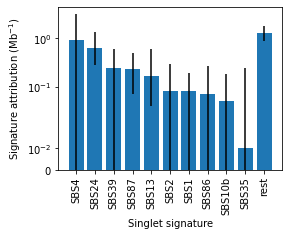

In [15]:
%matplotlib inline
plt.figure(figsize=(4,3))

plot_signature_bar(X_hrtw[SBS_columns], n_top=10)
plt.xlabel('Singlet signature')

sbs_ylims = plt.ylim()

plt.savefig('figs/univariate/attribution/hartwig-sbs.eps', bbox_inches = "tight")
plt.savefig('figs/univariate/attribution/hartwig-sbs.png', bbox_inches = "tight")
plt.savefig('figs/univariate/attribution/hartwig-sbs.pdf', bbox_inches = "tight")
plt.savefig('figs/univariate/attribution/hartwig-sbs.svg', bbox_inches = "tight")

In [16]:
sbs4_quartiles = X_hrtw['SBS4'].describe()[['25%', '50%', '75%']]
sbs4_iqr = 'IQR: {}-{}'.format(sbs4_quartiles['25%'], sbs4_quartiles['75%'])
print('SBS4, median:', sbs4_quartiles['50%'], f'({sbs4_iqr})')

SBS4, median: 0.91 (IQR: 0.0-3.14)


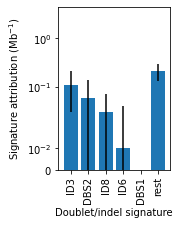

In [17]:
plt.figure(figsize=(2,3))

plot_signature_bar(X_hrtw[DB_columns + ID_columns], n_top=5)
plt.xlabel('Doublet/indel signature')
# Set to same scale as single base substitution attributions. 
plt.ylim(sbs_ylims)

plt.savefig('figs/univariate/attribution/hartwig-id-dbs.eps', bbox_inches = "tight")
plt.savefig('figs/univariate/attribution/hartwig-id-dbs.png', bbox_inches = "tight")
plt.savefig('figs/univariate/attribution/hartwig-id-dbs.pdf', bbox_inches = "tight")
plt.savefig('figs/univariate/attribution/hartwig-id-dbs.svg', bbox_inches = "tight")

Higest indel: ID3 (tabacco smoking). Highest doublet base substitution: DBS2 [tobacco smoking + endogenous and/or exogenous mutagens (e.g., acetaldehyde)].
Lets describe their values:

In [18]:
print('ID3: median =', X_hrtw['ID3'].median(), 'mean =', X_hrtw['ID3'].mean())
print('DBS2: median =', X_hrtw['DBS2'].median(), 'mean =', X_hrtw['DBS2'].mean())

ID3: median = 0.11 mean = 0.16485148514851483
DBS2: median = 0.06 mean = 0.09900990099009899


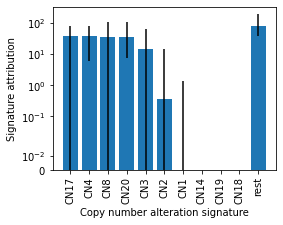

In [19]:
plt.figure(figsize=(4,3))

plot_signature_bar(X_hrtw[CN_columns], n_top=10)
plt.xlabel("Copy number alteration signature")
# Set to same scale as single base substitution attributions. 
# plt.ylim(sbs_ylims)
plt.ylabel('Signature attribution')

plt.savefig('figs/univariate/attribution/hartwig-cn.eps', bbox_inches = "tight")
plt.savefig('figs/univariate/attribution/hartwig-cn.png', bbox_inches = "tight")
plt.savefig('figs/univariate/attribution/hartwig-cn.pdf', bbox_inches = "tight")
plt.savefig('figs/univariate/attribution/hartwig-cn.svg', bbox_inches = "tight")

Highest median attribution copy number signature CN17: homologous recombination deficiency.
What is its mean and median value?

In [20]:
print('CN17: median =', X_hrtw['CN17'].median(), 'mean =', X_hrtw['CN17'].mean())

CN17: median = 37.18598756810596 mean = 46.51650332700719


## Durable benefit

Number of signatures to test:

In [21]:
print('SBS signatures: n =',len(SBS_columns))
print('DB signatures: n =', len(DB_columns))
print('ID signatures: n =', len(ID_columns))
print('CN signatures: n =', len(CN_columns))
print('total:', len(SBS_columns + DB_columns + ID_columns + CN_columns))

SBS signatures: n = 47
DB signatures: n = 11
ID signatures: n = 17
CN signatures: n = 20
total: 95


Number of patients tested:

In [22]:
# For the univariate DB analysis, we are only interested in labelled examples.
y_hrtw = X_hrtw['Durable benefit'].replace({'Yes': 1, 'No': 0})
notna_hrtw = y_hrtw.notna()

print('m =', X_hrtw[notna_hrtw].shape[0])

m = 93


In [23]:
stats_hrtw = get_significant_signatures(X_hrtw[notna_hrtw], SBS_columns + DB_columns + ID_columns + CN_columns, condition=y_hrtw[notna_hrtw].astype(bool), alternative='two-sided')
stats_hrtw[stats_hrtw['pvalue-corrected'] <= 0.05]

statistic    pvalue pvalue-corrected
SBS4    0.44883  0.000153          0.01449
SBS87  0.428363  0.000358         0.016999

In [24]:
# Collect all test statistics and write to disk to make a new spreadsheet.
sbs_analysed.loc[SBS_columns, ['statistic', 'pvalue', 'pvalue-corrected']] = stats_hrtw.loc[SBS_columns]
db_analysed.loc[DB_columns, ['statistic', 'pvalue', 'pvalue-corrected']] = stats_hrtw.loc[DB_columns]
indel_analysed.loc[ID_columns, ['statistic', 'pvalue', 'pvalue-corrected']] = stats_hrtw.loc[ID_columns]
cn_analysed.loc[CN_columns, ['statistic', 'pvalue', 'pvalue-corrected']] = stats_hrtw.loc[CN_columns]

sbs_analysed.to_csv('supporting_material/signatures/sbs.csv')
db_analysed.to_csv('supporting_material/signatures/db.csv')
indel_analysed.to_csv('supporting_material/signatures/id.csv')
cn_analysed.to_csv('supporting_material/signatures/cn.csv')

## Whole genome sequencing signature

Let us do the same analysis on WGS. Do we get the same results?

In [25]:
hrtw_wgs_signatures = read_csv('../artifacts/hartwig_wgs_signature.tsv', sep='\t', index_col=0)
X_wgs = polish_variable_names(hrtw_wgs_signatures)

In [26]:
# For the univariate DB analysis, we are only interested in labelled examples.
y_hrtw = X_wgs['Durable benefit'].replace({'Yes': 1, 'No': 0})
notna_hrtw = y_hrtw.notna()
stats_wgs = get_significant_signatures(X_wgs[notna_hrtw], SBS_columns + DB_columns + ID_columns + CN_columns, condition=y_hrtw[notna_hrtw].astype(bool), alternative='two-sided')
stats_wgs[stats_wgs['pvalue-corrected'] <= 0.05]

statistic    pvalue pvalue-corrected
SBS4  0.445906  0.000172         0.008147
DBS2   0.46345  0.000079         0.007546
DBS6  0.434211  0.000284         0.008988
ID3   0.385965  0.001846          0.04384

Print the q-values in LaTeX format.

In [27]:
for idx, row in stats_wgs[stats_wgs['pvalue-corrected'] <= 0.05].iterrows():
    print(idx, format_p_value(row['pvalue-corrected'], format='compact'))

SBS4 $0.0081$
DBS2 $0.0075$
DBS6 $0.0090$
ID3 $0.044$


- **DBS2**: Exposure to tobacco smoking as well as other endogenous and/or exogenous mutagens (e.g., acetaldehyde).
- **DBS6**: Unknown.
- **ID3**: Tabacco smoking.

In [28]:
stats_wgs.loc['SBS87']

statistic           0.065789
pvalue              0.999788
pvalue-corrected         1.0
Name: SBS87, dtype: object

## Correlation of signatures:
Lets determine the correlation of our signatures, while accounting for target label.

In [29]:
X_pos = X_hrtw[X_hrtw['Durable benefit'] == 'Yes']
X_neg = X_hrtw[X_hrtw['Durable benefit'] == 'No']

First, overall correlation.

In [30]:
kendalltau(X_pos['SBS4'], X_pos['SBS87'])

KendalltauResult(correlation=0.4078960204171974, pvalue=0.0006082767052912667)

In [31]:
kendalltau(X_neg['SBS4'], X_neg['SBS87'])

KendalltauResult(correlation=0.28508033327595794, pvalue=0.002812590069185066)

Next, we compute the correlation when normalising by TMB.

In [32]:
tmb_pos = X_hrtw.loc[X_pos.index, 'tmb']
tmb_neg = X_hrtw.loc[X_neg.index, 'tmb']

c_pos = kendalltau(X_pos['SBS4']/tmb_pos, X_pos['SBS87']/tmb_pos)
print(format_p_value(c_pos.correlation, symbol=r'\rho', format='compact'))
print(format_p_value(c_pos.pvalue, symbol='p', format='compact'))

$\rho = -0.036$
$p = 0.76$


In [33]:
c_neg = spearmanr(X_neg['SBS4']/tmb_neg, X_neg['SBS87']/tmb_neg)
print(format_p_value(c_neg.correlation, symbol=r'\rho', format='compact'))
print(format_p_value(c_neg.pvalue, symbol='p', format='compact'))

$\rho = -0.0082$
$p = 0.95$


## Detailed analysis significant signatures

- **SBS4**: Associated with tobacco smoking. Its profile is similar to the mutational spectrum observed in experimental systems exposed to tobacco carcinogens such as benzo[a]pyrene. SBS4 is, therefore, likely due to direct DNA damage by tobacco smoke mutagens.
- **SBS87**: Thiopurine chemotherapy treatment, experimentally validated.

In [34]:
print('SBS4, p_value: ', format_p_value(stats_hrtw.loc['SBS4', 'pvalue-corrected'], format='compact'))
print('SBS87, p_value: ', format_p_value(stats_hrtw.loc['SBS87', 'pvalue-corrected'], format='compact'))

SBS4, p_value:  $0.014$
SBS87, p_value:  $0.017$


Earlier work found a relation between outcome and **SBS1**:
Chong, Wei, et al. "Association of clock-like mutational signature with immune checkpoint inhibitor outcome in patients with melanoma and NSCLC." Molecular Therapy-Nucleic Acids 23 (2021): 89-100.

Lets inspect the significance of this signature without multiple testing correction:

In [35]:
stats_hrtw.loc[['SBS1', 'SBS2', 'SBS13']]

statistic    pvalue pvalue-corrected
SBS1   0.188596  0.358777              1.0
SBS2   0.147661  0.658103              1.0
SBS13  0.288012  0.040206         0.763911

In [36]:
def plot_pvalue_text(x_values, y_values, text, ax):
    """Annotate groups with p-value text."""
    x1, x2 = x_values[0], x_values[1]
    
    ylim = ax.get_ylim()
    # height = 0.05 * y_values.max()
    height = 0.05 * ylim[1]
    y =  y_values.max() + height

    # Plot bar.
    ax.plot([x1, x1, x2, x2], [y, y + height, y + height, y], lw=1.5, c='k')
    
    # Plot p-value text.
    ax.text((x1+x2)*.5, y + height, text, ha='center', va='bottom', color='k')
    
    # Adjust limits to encompass annotation.
    ax.set_ylim(ylim[0], max([y + 4 * height, ylim[1]]))

def plot_pvalue(x_values, y_values, pvalue: float, ax, symbol='p'):
    """Annotate groups with p-value text."""
    p_label = format_p_value(pvalue, symbol=symbol, format='compact')
    plot_pvalue_text(x_values, y_values, p_label, ax)

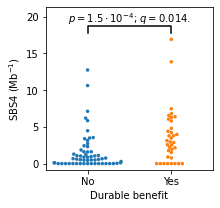

In [37]:
# statistical annotation
plt.figure(figsize=(3, 3))
sns.swarmplot(x='Durable benefit', y=X_hrtw['SBS4'], data=X_hrtw, s=3.5)

q_label = format_p_value(stats_hrtw.loc['SBS4', 'pvalue-corrected'], symbol='q', format='compact')
p_label = format_p_value(stats_hrtw.loc['SBS4', 'pvalue'], symbol='p', format='compact')
label_significance = p_label + '; ' + q_label + '.'
plot_pvalue_text(x_values=[0, 1], y_values=X_hrtw['SBS4'], text=label_significance, ax=plt.gca())
plt.ylabel('SBS4 (Mb${}^{-1}$)')

# Make all y-axis scales similar.
sbs4_lims = plt.ylim()

plt.savefig('figs/univariate/hartwig-db-sbs4.eps', bbox_inches = "tight")
plt.savefig('figs/univariate/hartwig-db-sbs4.png', bbox_inches = "tight")
plt.savefig('figs/univariate/hartwig-db-sbs4.pdf', bbox_inches = "tight")
plt.savefig('figs/univariate/hartwig-db-sbs4.svg', bbox_inches = "tight")

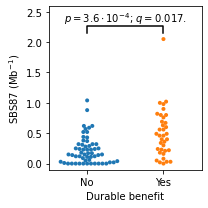

In [38]:
plt.figure(figsize=(3, 3))

sns.swarmplot(x='Durable benefit', y='SBS87', data=X_hrtw,  s=4)
q_label = format_p_value(stats_hrtw.loc['SBS87', 'pvalue-corrected'], symbol='q', format='compact')
p_label = format_p_value(stats_hrtw.loc['SBS87', 'pvalue'], symbol='p', format='compact')
label_significance = p_label + '; ' + q_label + '.'
plot_pvalue_text(x_values=[0, 1], y_values=X_hrtw['SBS87'], text=label_significance, ax=plt.gca())
plt.ylabel('SBS87 (Mb${}^{-1}$)')

plt.tight_layout()
plt.savefig('figs/univariate/hartwig-db-sbs87.eps', bbox_inches = "tight")
plt.savefig('figs/univariate/hartwig-db-sbs87.png', bbox_inches = "tight")
plt.savefig('figs/univariate/hartwig-db-sbs87.pdf', bbox_inches = "tight")
plt.savefig('figs/univariate/hartwig-db-sbs87.svg', bbox_inches = "tight")

By request of the reviewer, we also make an analysis with tumor mutational burden.

In [39]:
stats_hrtw

statistic    pvalue pvalue-corrected
SBS1  0.188596  0.358777              1.0
SBS2  0.147661  0.658103              1.0
SBS3  0.111111  0.912915              1.0
SBS4   0.44883  0.000153          0.01449
SBS6  0.048246       1.0              1.0
...        ...       ...              ...
CN17  0.157895   0.57683              1.0
CN18  0.035088       1.0              1.0
CN19  0.067251   0.99968              1.0
CN20  0.152047  0.623523              1.0
CN21  0.131579  0.782296              1.0

[95 rows x 3 columns]

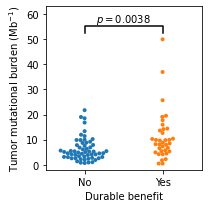

In [40]:
plt.figure(figsize=(3, 3))

sns.swarmplot(x="Durable benefit", y="tmb", data=X_hrtw, s=4)
# Compute p-value using Kolmogorov-Smirnov test comparing the groups.
tmb_stats_hrtw = get_significant_signatures(
    X_hrtw[notna_hrtw],
    columns=["tmb"],
    condition=X_hrtw[notna_hrtw]["Durable benefit"] == "Yes",
)
plot_pvalue(
    x_values=[0, 1],
    y_values=X_hrtw["tmb"],
    pvalue=tmb_stats_hrtw.loc["tmb", "pvalue"],
    ax=plt.gca(),
    symbol="p",
)
plt.ylabel("Tumor mutational burden (Mb${}^{-1}$)")

plt.tight_layout()
plt.savefig("figs/univariate/hartwig-db-tmb.eps", bbox_inches="tight")
plt.savefig("figs/univariate/hartwig-db-tmb.png", bbox_inches="tight")
plt.savefig("figs/univariate/hartwig-db-tmb.pdf", bbox_inches="tight")
plt.savefig("figs/univariate/hartwig-db-tmb.svg", bbox_inches="tight")


When `SBS4` and `SBS84` are combined, they are responsible for this amount of all non-synonymous mutations.

In [41]:
non_synonymous_fraction = X_hrtw[['SBS4', 'SBS87']].sum(axis=1) / X_hrtw['tmb']
non_synonymous_fraction.describe()

count    101.000000
mean       0.244018
std        0.186613
min        0.000000
25%        0.083744
50%        0.202381
75%        0.413088
max        0.721382
dtype: float64

## ROC analysis
Next, we use the individual features to perform ROC analysis on the discovery set.

In [42]:
sbs4_auc = bootstrap_score(y_hrtw[notna_hrtw], X_hrtw.loc[notna_hrtw, 'SBS4'], metric=roc_auc_score)
sbs87_auc = bootstrap_score(y_hrtw[notna_hrtw], X_hrtw.loc[notna_hrtw, 'SBS87'], metric=roc_auc_score)

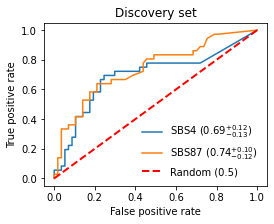

In [43]:
f = plt.figure(figsize=(4,3))
ax = f.gca()

# Plot SBS4.
RocCurveDisplay.from_predictions(
    y_hrtw[notna_hrtw],
    X_hrtw.loc[notna_hrtw, 'SBS4'],
    name='SBS4\n',
    ax=ax,
)
ax.lines[-1].set_label('SBS4 ({})'.format(sbs4_auc.latex()))

# Plot SBS87.
RocCurveDisplay.from_predictions(
    y_hrtw[notna_hrtw],
    X_hrtw.loc[notna_hrtw, 'SBS87'],
    name='SBS87\n',
    ax=ax,
)
ax.lines[-1].set_label('SBS87 ({})'.format(sbs87_auc.latex()))

ax.plot([0, 1], [0, 1], '--', color='r', linewidth=2, label='Random (0.5)')
plt.title('Discovery set')

plt.legend(frameon=False)
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.savefig('figs/univariate/hartwig-roc-individual-signatures.eps', bbox_inches = "tight")
plt.savefig('figs/univariate/hartwig-roc-individual-signatures.png', bbox_inches = "tight")
plt.savefig('figs/univariate/hartwig-roc-individual-signatures.pdf', bbox_inches = "tight")

## Prior chemotherapy

In [44]:
result = get_significant_signatures(X_hrtw, SBS_columns + DB_columns + ID_columns + CN_columns, condition=X_hrtw['Prior chemotherapy'] == 'Yes', alternative='two-sided')
result[result['pvalue-corrected'] <= 0.05]

Empty DataFrame
Columns: [statistic, pvalue, pvalue-corrected]
Index: []

## Prior radiotherapy

In [45]:
result = get_significant_signatures(X_hrtw, SBS_columns + DB_columns + ID_columns + CN_columns, condition=X_hrtw['Prior radiotherapy'] == 'Yes', alternative='two-sided')
result[result['pvalue-corrected'] <= 0.05]

Empty DataFrame
Columns: [statistic, pvalue, pvalue-corrected]
Index: []

## Treatment naive

In [46]:
result = get_significant_signatures(X_hrtw, SBS_columns+ DB_columns + ID_columns + CN_columns, condition=X_hrtw['Treatment naive'] == 'Yes', alternative='two-sided')
result[result['pvalue-corrected'] <= 0.05]

Empty DataFrame
Columns: [statistic, pvalue, pvalue-corrected]
Index: []

Plot the signature that is most signficantly correlated with treatment naive mutations.

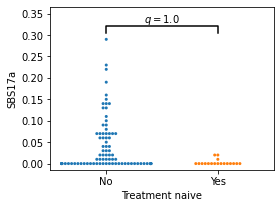

In [47]:
plt.figure(figsize=(4, 3))

sns.swarmplot(x='Treatment naive', y='SBS17a', data=X_hrtw,  s=3)
plot_pvalue(x_values=[0, 1], y_values=X_hrtw['SBS17a'], pvalue=stats_hrtw.loc['SBS17a', 'pvalue-corrected'], ax=plt.gca(), symbol='q')

# Miao

In [48]:
miao = read_csv('../artifacts/miao_wes_signature.tsv', sep='\t', index_col=0)

In [49]:
y_miao = miao['durable_benefit'].copy()
not_na_miao = y_miao.notna()
X_miao = polish_variable_names(miao)

### Distribution of signatures

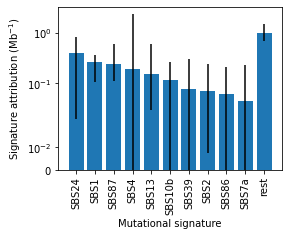

In [50]:
plt.figure(figsize=(4,3))

plot_signature_bar(X_miao[SBS_columns], n_top=10)

sbs_ylims = plt.ylim()

plt.savefig('figs/univariate/attribution/miao-sbs.eps', bbox_inches = "tight")
plt.savefig('figs/univariate/attribution/miao-sbs.png', bbox_inches = "tight")
plt.savefig('figs/univariate/attribution/miao-sbs.pdf', bbox_inches = "tight")
plt.savefig('figs/univariate/attribution/miao-sbs.svg', bbox_inches = "tight")

### Association with durable benefit

In [51]:
stats_miao = get_significant_signatures(X_miao[not_na_miao], ['SBS4', 'SBS87'], condition=y_miao[not_na_miao].astype(bool), alternative='two-sided')
stats_miao

statistic    pvalue pvalue-corrected
SBS4   0.357143  0.046825         0.046825
SBS87  0.401099  0.018504         0.037009

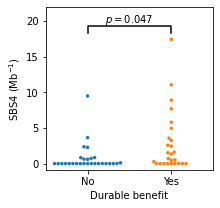

In [52]:
plt.figure(figsize=(3,3))
sns.swarmplot(x='Durable benefit', y='SBS4', data=X_miao, s=3.5, order=['No', 'Yes'])
plot_pvalue(x_values=[0, 1], y_values=X_miao['SBS4'], pvalue=stats_miao.loc['SBS4', 'pvalue'], ax=plt.gca())
plt.ylabel('SBS4 (Mb${}^{-1}$)')

plt.savefig('figs/univariate/miao-db-sbs4.eps', bbox_inches = "tight")
plt.savefig('figs/univariate/miao-db-sbs4.png', bbox_inches = "tight")
plt.savefig('figs/univariate/miao-db-sbs4.pdf', bbox_inches = "tight")

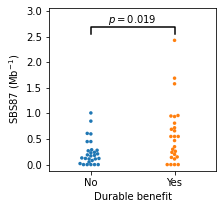

In [53]:
plt.figure(figsize=(3,3))

sns.swarmplot(x='Durable benefit', y='SBS87', data=X_miao, s=3.5, order=['No', 'Yes'])
plot_pvalue(x_values=[0, 1], y_values=X_miao['SBS87'], pvalue=stats_miao.loc['SBS87', 'pvalue'], ax=plt.gca())
plt.ylabel('SBS87 (Mb${}^{-1}$)')

plt.savefig('figs/univariate/miao-db-sbs87.eps', bbox_inches = "tight")
plt.savefig('figs/univariate/miao-db-sbs87.png', bbox_inches = "tight")
plt.savefig('figs/univariate/miao-db-sbs87.pdf', bbox_inches = "tight")

## ROC curve analysis

In [54]:
sbs4_auc = bootstrap_score(y_miao[not_na_miao], X_miao.loc[not_na_miao, 'SBS4'], metric=roc_auc_score)
sbs87_auc = bootstrap_score(y_miao[not_na_miao], X_miao.loc[not_na_miao, 'SBS87'], metric=roc_auc_score)

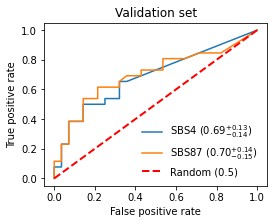

In [55]:
f = plt.figure(figsize=(4,3))
ax = f.gca()

RocCurveDisplay.from_predictions(
    y_miao[not_na_miao],
    X_miao.loc[not_na_miao, 'SBS4'],
    name='SBS4\n',
    ax=ax,
)
ax.lines[-1].set_label('SBS4 ({})'.format(sbs4_auc.latex()))

RocCurveDisplay.from_predictions(
    y_miao[not_na_miao],
    X_miao.loc[not_na_miao, 'SBS87'],
    name='SBS87\n',
    ax=ax,
)
ax.lines[-1].set_label('SBS87 ({})'.format(sbs87_auc.latex()))

ax.plot([0, 1], [0, 1], '--', color='r', linewidth=2, label='Random (0.5)')
plt.legend(frameon=False)
plt.title('Validation set')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.savefig('figs/univariate/miao-roc-individual-signatures.eps', bbox_inches = "tight")
plt.savefig('figs/univariate/miao-roc-individual-signatures.png', bbox_inches = "tight")
plt.savefig('figs/univariate/miao-roc-individual-signatures.pdf', bbox_inches = "tight")